In [1]:
### Prepare module structure ###

import sys
sys.path.append('../')

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


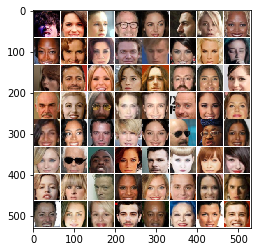

torch.Size([64, 3, 64, 64])


In [4]:
### LOAD DATA ###

dataloader, imsize = load(name='CelebA64', path='/home/shared/phase-retrieval/data/CelebA64.h5', batch_size=64)

sample = next(iter(dataloader['train']))
plot_grid(sample)
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [5]:
### LOAD MODEL ###

latent_dim = 100

gen = models.DCGenerator(ngpu=1, ngf=128, nz=latent_dim, nc=3)
gen.load_state_dict(torch.load("/home/shared/phase-retrieval/models/DCGAN_CelebA/netG_epoch_99.pth"));

print("{} trainable parameters in generator".format(sum(p.numel() for p in gen.parameters() if p.requires_grad)))

12658432 trainable parameters in generator


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


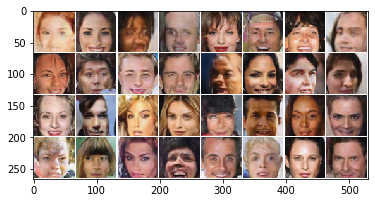

In [6]:
### Test model ###

gen.to(device)
plot_grid(gen(torch.randn((32, latent_dim, 1, 1), device=device)).cpu().detach()*0.5+0.5)

In [7]:
### Hand Paper (adapted) ###

def calc_meas(x):
    m = A.shape[1]
    N = x.shape[0]
    C = x.shape[1]
    compressed = (x.view(N, C, -1) @ A).view(N, C, m)
    return torch.abs(compressed)

def ganopt(sample_meas, gan, device, measurement_fn=calc_meas,
           z_shape=(100, 1, 1), optim_lr=1e-1, max_steps=5000, max_loss=0.0):
    
    gan.to(device)
    gan.eval()
    
    N = sample_magnitudes.shape[0]
    z = torch.randn((N, *z_shape), requires_grad=True, device=device)
    optimizer = optim.Adam([z], lr=optim_lr)
    
    losses = []
    last_out = gan(z, unit_interval=True)
    
    with tqdm_notebook(total=max_steps) as progress_bar:
        for i in range(max_steps):

            meas = measurement_fn(last_out)
            mse_all = torch.mean((meas - sample_meas) ** 2, dim=tuple(np.arange(len(meas.shape))[1:]))
            loss = torch.sum(mse_all)

            if loss < max_loss:
                break

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            last_out = gan(z, unit_interval=True)

            losses.append(loss.detach().cpu().item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))
            progress_bar.update(1)

    return last_out.detach(), losses, mse_all

In [44]:
m = 64 # (64, 128, 256, 512, 1024, 2048, 4096)

import pickle

#A = (torch.randn(imsize[1] * imsize[2], m) / m).to(device)
#pickle.dump(A, open("../cache/A/A{}.p".format(m), "wb"))

A = pickle.load(open("../cache/A/A{}.p".format(m), "rb")).to(device)

print(A.shape)

torch.Size([4096, 64])


In [ ]:
### Test one sample A measurements ###

num_batches = 16 # 16
batch_size = 64
max_steps = 10000
optim_lr= 1e-1
restarts = 3

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)


for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)
    test_meas = calc_meas(test_sample)
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()

    for r in range(restarts):
        print("\tRestart {0} of {1}".format(r+1, restarts))
        cur_out_results, cur_loss, cur_mse_all = ganopt(sample_meas=test_meas, gan=gen, device=device,
                                                        measurement_fn=calc_meas, z_shape=(latent_dim, 1, 1),
                                                        optim_lr=optim_lr, max_steps=max_steps)
        cur_out_results = cur_out_results.cpu().numpy()
        
        for i in range(batch_size):
            mse = mse_all[batch_size * batch_i + i]
            if cur_mse_all[i] < mse:
                out_results[batch_size * batch_i + i] = cur_out_results[i]
                mse_all[batch_size * batch_i + i] = cur_mse_all[i]

    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.semilogy(cur_loss)
plt.show()

	Restart 1 of 3


In [ ]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/DCGAN_CelebA/Ameas64_original_1024.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/DCGAN_CelebA/Ameas64_1024.p", "wb"))

In [5]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("/home/shared/phase-retrieval/test/DCGAN_CelebA/Ameas64_original_1024.p", "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/DCGAN_CelebA/Ameas64_1024.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


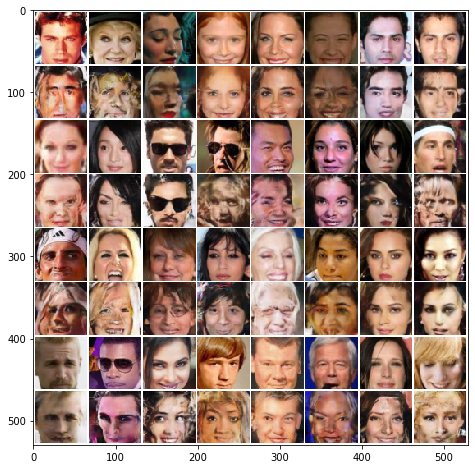

In [6]:
print("Output under minimized magnitude distance:")

to_plot = np.stack([out_original[:32].reshape(4, 24, 64, 64), 
                    out_results[:32].reshape(4, 24, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
           
plot_grid(to_plot, figsize=(8, 8), file="../out/dcgan/celeba/{0}{1}.png".format('Ameas64_1024_', time.strftime("%Y%m%d_%H%M%S")))
#plot_grid(to_plot, figsize=(8, 8))

In [8]:
benchmark(pred=out_results, true=out_original, check=["mse", "mae", "ssim", "magn", "imcon"])

Signal error:
  MSE: 0.019996634559318636, std: 0.012544589203341274
  MAE: 0.10116755846735166, std: 0.02969081911503571
  SSIM: 0.55782534268495, std: 0.1218117667546492

Magnitude error:
  MSE Magnitude: 31.047126623873616, std: 19.477959693896388

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.02000 | 0.1012 | 0.5578 | 31.05 |


## Test A measurements random init (1024 samples)

For small m small lr would be better for reducing mse error, but 1e-1 still reduces the measurement error best

| Nr Type | iterations | restarts | lr | m | MSE | MAE | SSIM | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| 2 | 10000 | 3 | 1e-1 | 4096 | 0.003573 | 0.04392 | 0.8345 | 6.976 |
| 2 | 10000 | 3 | 1e-1 | 2048 | 
| 2 | 10000 | 3 | 1e-1 | 1024 | 0.003944 | 0.04605 | 0.8236 | 7.495 |
| 2 | 10000 | 3 | 1e-1 | 512 | 
| 2 | 10000 | 3 | 1e-1 | 256 |
| 2 | 10000 | 3 | 1e-1 | 128 | 0.01042 | 0.07359 | 0.6804  | 16.88 |
| 2 | 10000 | 3 | 1e-1 | 64 |  0.02000 | 0.1012 | 0.5578 | 31.05 |
| 2 | 10000 | 3 | 1e-1 | 32 |


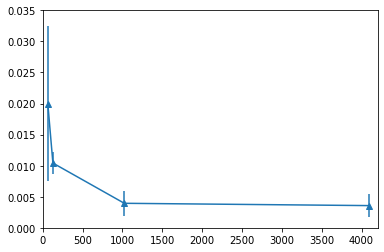

In [12]:
mse = [0.02000, 0.01042, 0.003944, 0.003573]
m = [64, 128, 1024, 4096]
std = [0.01254, 0.001801, 0.002024, 0.001801]

axes = plt.gca()
axes.set_xlim([0, 4200])
axes.set_ylim([0, 0.035])
plt.errorbar(m, mse, std, marker='^')
plt.show()

### Raw outputs:

m=4096:

Signal error:
  MSE: 0.003573360895964422, std: 0.0018014035070159629
  MAE: 0.043917365124720775, std: 0.009906349424678234
  SSIM: 0.834500928619162, std: 0.05116862003228941

Magnitude error:
  MSE Magnitude: 6.975657361224616, std: 3.8793204492103013


m=1024:

Signal error:
  MSE: 0.003944294324279391, std: 0.0020241895134105376
  MAE: 0.046049419693258854, std: 0.010548620041349259
  SSIM: 0.8235857609664231, std: 0.05513045458405729

Magnitude error:
  MSE Magnitude: 7.495008713406486, std: 4.1146832345591715


m=128:

Signal error:
  MSE: 0.003573360895964422, std: 0.0018014035070159629
  MAE: 0.043917365124720775, std: 0.009906349424678234
  SSIM: 0.834500928619162, std: 0.05116862003228941

Magnitude error:
  MSE Magnitude: 6.975657361224616, std: 3.8793204492103013


m=64:

Signal error:
  MSE: 0.019996634559318636, std: 0.012544589203341274
  MAE: 0.10116755846735166, std: 0.02969081911503571
  SSIM: 0.55782534268495, std: 0.1218117667546492

Magnitude error:
  MSE Magnitude: 31.047126623873616, std: 19.477959693896388
